In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import category_encoders as ce
import scipy
import mysql.connector

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from app.Investigation.OpenStreetMaps.associate_edges_to_operation import OsmDataAdapter
from app.Investigation.Route_segmentation.segmentation import gen_traces

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

# Leyendo los datos de operación de vehículos

Los datos se recogieron de dos vehículos Renault ZOE diferentes en la ciudad de Medellín, los datos contienen:
- 448,7 km de un mismo conductor durante tres días.
- 226 km de datos de registro de otro conductor durante dos días.  
- Rutas predefinidas de 25 km la cual fue conducida por 12 usuarios diferentes con edades comprendidas entre los 24 y los 50 años, y diferentes géneros. 

Las rutas se realizaron a diferentes horas, entre las 8:00 y las 17:30, y algunas de ellas se realizaron con tráfico. 

Las rutas incluían todos los días de la semana, así como los fines de semana y los días festivos.

El dataset original contiene mediciones instantáneas con la siguiente información:

## Información sobre el vehículo:
-'timestamp',
-'operative_state',
-'latitude',
-'longitude',
-'elevation',
-'slope',
-'speed', 
-'odometer', 
-'user_id', 
-'batt_temp',
-'ext_temp',
-'power_kw',
-'acceleration',
-'capacity',
-'vehicle_id', 
-'voltage',
-'current',
-'throttle',
-'regen_brake',
-'consumption',
-'range_est',
-'range_ideal',
-'range_full',
-'energy',
-'mass', 
-'mean_acc',
-'run',
-'en_pot',
-'mean_speed',
-'timestamp2', 
 
 ### Información sobre la vía:
-'oneway',
-'lanes',
-'name',
-'highway', 
-'grade', 
-'grade_abs',
-'bridge',
-'tunnel',
-'width',
-'name_str',
-'highway_str',
-'kwh_km'


A partir de éstos datos, se ha creado un nuevo dataset segmentos de rutas: features.csv, conteniendo indicadores estadísticos de los atributos de comportamiento del vehículo y su conducción, los atributos de la carretera, la tasa de consumo energético del segmento. El algoritmo de segmentación tuvo las siguientes restricciones: la longitud del segmento se fijó en 1000m. Además, cada punto del segmento debe pertenecer a la misma vía y, por tanto, el tipo de carretera y la velocidad nominal serán constantes para cada segmento.

### Información sobre la conducción del vehículo:
- 'num_acc_min', 'num_acc_fr_min', 'prom_sobrepaso_acc',
'prom_sobrepaso_fren', 'prom_abs_acc', 'std_acc', 'num_jerk_acc_min',
'num_jerk_freno_min', 'prom_sobrepaso_jerk_acc',
'prom_sobrepaso_jerk_freno', 'prom_abs_jerk', 'std_jerk', 'std_power',
'prom_abs_power', 'consumption', 'consumption_per_km',
'num_current_min', 'num_current_fr_min', 'prom_sobrepaso_current',
'prom_sobrepaso_current_fr', 'prom_abs_current', 'std_current',
'std_current_std_jerk', 
'max_current', 'max_jerk', 'max_acc', 'max_power', 'min_power',
'max_speed', 'mean_speed', 'std_speed', 'iqr_power', 'mean_soc',
'mean_temp', 'travel_time', 'idle_time', , 'user_id',
 
### Información sobre las características del vehículo
- 'vehicle_id', 'mass'

### Información sobre la vía:
- 'traffic_factor', 'highway', 'slope', 'nominal_speed', 'kms', 'lights', 'highway'


In [3]:
cnx = mysql.connector.connect(user='admin', password='actuadores',
                              host='104.236.94.94',
                              database='monitoreodb')
query = "SELECT * from operation"

In [4]:
all_data = pd.read_sql_query(query, cnx, index_col='id')
all_data.dropna(axis=1, how="all", inplace=True)

In [6]:
osm_adapter = OsmDataAdapter()
all_data_with_osm = osm_adapter.add_osmn_attributes(all_data)


empieza nearest_edges


TypeError: get_nearest_edges_of_segments() takes 2 positional arguments but 3 were given

In [ ]:
segments = gen_traces(all_data)
segments.head(5)

In [6]:
segments.to_csv("segments_renault.csv")


NameError: name 'segments' is not defined

Para la variable categórica del tipo de vía 'higway', utilizaremos el encoder m_estimate.
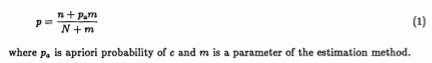
 
el cual se entrena con un modelo probabilístico basado en el efecto que tiene cada categoría sobre el otra variable numérica, que para este caso será el consumo por kilometro (kWh/km) 'consumption_per_km'.



In [ ]:
encoder = ce.MEstimateEncoder(cols=['highway'], return_df=True)

encoder.fit(segments[['highway']], segments['consumption_per_km'])
X_cleaned = encoder.transform(segments[['highway']])
X_cleaned.rename(columns={"highway": "highway_enc"}, inplace=True)
segments['highway_enc'] = X_cleaned.highway_enc
segments['highway_enc'].unique()

Eliminamos las variables categóricas que no se utilizarán en el modelo, asi como variables de la ruta como numero de semaforos del segmento, ya que lo que nos interesa es categorizar a los usuarios y no las rutas en este caso.

In [ ]:
X = segments.drop(columns=['test_id', 'user_id',	'vehicle_id', 'end_time',	'mass','lights',	'end_odometer', 'slope_cat', 'consumption', 'kms'])
X

In [ ]:
# se eliminan las variables que no son interesantes para el problema de clusterización, ya que no hacen parte de los atributos de conducción
X = segments.drop(columns=['test_id', 'user_id',	'vehicle_id', 'end_time',	'mass',	'lights',	'end_odometer', 'slope_cat', 'consumption', 'kms', 'highway']).values

# Escalamos antes de aplicar PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hacemos PCA para reducir la dimensionalidad del problema
pca = PCA()
pca.fit(X_scaled)
print('The explained variances with 2 components is:', pca.explained_variance_ratio_[0:1].sum())
n_components = 2

if n_components == 2:
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_transformed = pca.transform(X_scaled)
    fig = plt.figure(figsize=[10, 10])
    plt.scatter(x=X_transformed[:, 0], y=X_transformed[:, 1], s=10)

elif n_components == 3:
    pca = PCA(n_components=3)
    pca.fit(X_scaled)
    X_transformed = pca.transform(X_scaled)
    fig = px.scatter_3d(x=X_transformed[:, 0], y=X_transformed[:, 1], z=X_transformed[:, 2], log_x=False, size=np.repeat([4], len(X)))
    fig.show()

In [ ]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=[10,5])
dendrogram = sch.dendrogram(sch.linkage(X_transformed, method = 'ward'))

plt.title('Dendograma')
plt.xlabel('Segmentos')
plt.ylabel('Distancias Euclidianas')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, 
                    affinity = 'euclidean', 
                    linkage = 'ward')

y_hc = hc.fit_predict(X_transformed)

In [ ]:
# Visualising the clusters
plt.figure(figsize=[9,9])
plt.scatter(X_transformed[y_hc == 0, 0], X_transformed[y_hc == 0, 1], s = 20, c = 'red', label = 'Cluster 1')
plt.scatter(X_transformed[y_hc == 1, 0], X_transformed[y_hc == 1, 1], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(X_transformed[y_hc == 2, 0], X_transformed[y_hc == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(X_transformed[y_hc == 3, 0], X_transformed[y_hc == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
plt.title('Clusters of drivers')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend()
plt.show()

In [ ]:

segments['cluster'] = y_hc+1
sns.pairplot(segments.sort_values(['slope']), hue='cluster', palette='Paired', vars=['max_power', 'mean_speed', 'traffic_factor','std_power',
                                             'consumption_per_km'], kind= 'scatter')

Para éste problema de segmentación, la variable consumo por kilómetro es de grán interes ya que está directamente relacionada con el costo de operación de los vehículos. Industrias como car sharing, rentas de vehículos entre otras podrían tomas decisiones de cobro específicas a los usuarios de acuerdo con la clasificacíon donde se encuentre el ususario y por ende, sobre el costo que le está generando al empresa. Es por esto que es importante establecer una diferencia entre las medias de ámbos grupos utilizando t-tests como se muestra a continuación:

In [ ]:
t, p = scipy.stats.ttest_ind(segments['consumption_per_km'][(segments['cluster'] == 1)],
                             segments['consumption_per_km'][segments['cluster'] == 2 ])
print('Consumption difference between clusters')
print('t = ' + str(t))
print('p-value = ' + str(p), '\n')

Observamos que las medias son significativamente diferentes

In [ ]:
# plt.figure(figsize=[9,9])
# fig = plt.figure(figsize=[10, 10])
# ax = Axes3D(fig)
#fig = px.scatter_3d(segments['mean_speed'][y_hc == 0], segments['max_current'][y_hc == 0], segments['traffic_factor'][y_hc == 0]) #, color = 'red')  #, label = 'Cluster 1')
fig = px.scatter_3d(segments, x='mean_speed', y='max_current', z='traffic_factor',color='cluster', width=800, height=800)
# px.scatter_3d(segments['mean_speed'][y_hc == 2], segments['max_current'][y_hc == 2], segments['traffic_factor'][y_hc == 2]) #, c = 'green', label = 'Cluster 3')
# px.scatter_3d(segments['mean_speed'][y_hc == 3], segments['max_current'][y_hc == 3], segments['traffic_factor'][y_hc == 3]) #, c = 'cyan', label = 'Cluster 4')
# plt.title('Clusters of drivers')
# plt.xlabel('mean_speed kmh')
# plt.ylabel('max_current A')
# plt.legend()
fig.show()

# fig = px.scatter_3d(x=X_transformed[:, 0], y=X_transformed[:, 1], z=X_transformed[:, 2], log_x=False, size=np.repeat([4], len(X)))
#     fig.show()

Evaluamos el performance del modelo medieante el coheficiente de silueta

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4]

                
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_transformed) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters = n_clusters, 
                    affinity = 'euclidean', 
                    linkage = 'ward')
    cluster_labels = clusterer.fit_predict(X_transformed)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_transformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_transformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #             c="white", alpha=1, s=200, edgecolor='k')

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                 s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()